<a href="https://colab.research.google.com/github/AbrahamMulat/TensorFlow-deep-learning-Exercise-and-Project/blob/main/05_Transfer_learning_in_TensorFlow_Part_2_Fine_tuning_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🛠 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises
 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.
 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?
 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


--2022-10-27 12:49:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-27 12:49:18 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-10-27 12:49:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 142.251.45.16, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   166MB/s    in 1.0s    

2022-10-27 12:49:22 (166 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [4]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
# Check the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
len(train_data_10_percent.class_names)

10

### 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [9]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=2)

## Build a transfer learning model using the Keras Functional API.

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-trained pattern remains)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Resacling(1./255)(input)

# 5. pass the input to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="gloabal_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs into the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [11]:
# 9. Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [24]:
# 10. Fit the model (use less steps for validation so it's fast)
history_10_percent = model_1.fit(train_data_10_percent,
                                 epochs=10,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("transfer_learning_part2", "10_percent_feature_extract_exercise")]
                                 )

Saving TensorBoard log files to: transfer_learning_part2/10_percent_feature_extract_exercise/20221027-132713
Epoch 1/10
24/24 [==============================] - 5s 186ms/step - loss: 0.2025 - accuracy: 0.9707 - val_loss: 0.4382 - val_accuracy: 0.8651
Epoch 2/10
24/24 [==============================] - 5s 190ms/step - loss: 0.1863 - accuracy: 0.9693 - val_loss: 0.4711 - val_accuracy: 0.8520
Epoch 3/10
24/24 [==============================] - 4s 156ms/step - loss: 0.1821 - accuracy: 0.9760 - val_loss: 0.4528 - val_accuracy: 0.8569
Epoch 4/10
24/24 [==============================] - 4s 158ms/step - loss: 0.1674 - accuracy: 0.9707 - val_loss: 0.4585 - val_accuracy: 0.8536
Epoch 5/10
24/24 [==============================] - 4s 151ms/step - loss: 0.1584 - accuracy: 0.9853 - val_loss: 0.4559 - val_accuracy: 0.8536
Epoch 6/10
24/24 [==============================] - 4s 154ms/step - loss: 0.1458 - accuracy: 0.9813 - val_loss: 0.4651 - val_accuracy: 0.8487
Epoch 7/10
24/24 [=====================

In [15]:
# check layers in the base_model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# check base model summary
base_model.summary()

In [17]:
# Check summary of the model constructed with Functional API
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloabal_average_pooling_lay  (None, 1280)             0         
 er (GlobalAveragePooling2D)                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
model_1.layers

In [20]:
for layer in model_1.layers:
  print(layer.trainable)

True
False
True
True


In [22]:
# Check number of trainable layers in the base_model
print(len(model_1.layers[1].trainable_variables)) # layer at index 1 is efficientnet 

# this is the same as 
# print(len(base_model.trainable_variables))

0
0


In [23]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

### 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [28]:
base_model.trainable = True

# Freeze all layers except for the last 20 
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Check which layers are tunabel (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [29]:
# Recompile the model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
# check number of trainabel variables
print(len(model_1.trainable_variables))

21


In [34]:
# Fine tune for another 5 epochs
initial_epochs = 10
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_1 except with more trainable layers)
history_fine_tune_10_percent = model_1.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data_10_percent,
                                           initial_epoch=history_10_percent.epoch[-1], # start from the previous last epoch
                                           validation_steps=int(0.25*len(test_data_10_percent)),
                                           callbacks=[create_tensorboard_callback("transfer_learning_part2", "10_percent_feature_extract_exercise_fine_tune_last_20")])

Saving TensorBoard log files to: transfer_learning_part2/10_percent_feature_extract_exercise_fine_tune_last_20/20221027-134748
Epoch 10/20
24/24 [==============================] - 13s 255ms/step - loss: 0.4295 - accuracy: 0.8827 - val_loss: 0.6196 - val_accuracy: 0.7911
Epoch 11/20
24/24 [==============================] - 4s 161ms/step - loss: 0.0850 - accuracy: 0.9800 - val_loss: 0.4616 - val_accuracy: 0.8421
Epoch 12/20
24/24 [==============================] - 5s 191ms/step - loss: 0.0301 - accuracy: 0.9933 - val_loss: 0.5184 - val_accuracy: 0.8421
Epoch 13/20
24/24 [==============================] - 4s 159ms/step - loss: 0.0207 - accuracy: 1.0000 - val_loss: 0.4854 - val_accuracy: 0.8553
Epoch 14/20
24/24 [==============================] - 4s 158ms/step - loss: 0.0119 - accuracy: 0.9987 - val_loss: 0.4917 - val_accuracy: 0.8503
Epoch 15/20
24/24 [==============================] - 4s 159ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.4641 - val_accuracy: 0.8602
Epoch 16/20
24

In [35]:
# Evaluet the model on the whole test data
results_fine_tune_10_percent = model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 77ms/step - loss: 0.4448 - accuracy: 0.8852


### 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [37]:
base_model.trainable = True

# Freeze all layers except for the last 30 
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Check which layers are tunabel (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [38]:
# Recompile the model 
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
# check number of trainable layers
print(len(model_1.trainable_variables))

30


In [41]:
# Fine tune for another 10 epochs
initial_epochs = 20
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_1 except with more trainable layers)
history_fine_tune_10_percent = model_1.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data_10_percent,
                                           initial_epoch=history_fine_tune_10_percent.epoch[-1], # start from the previous last epoch
                                           validation_steps=int(0.25*len(test_data_10_percent)),
                                           callbacks=[create_tensorboard_callback("transfer_learning_part2", "10_percent_feature_extract_exercise_fine_tune_last_30")])

Saving TensorBoard log files to: transfer_learning_part2/10_percent_feature_extract_exercise_fine_tune_last_30/20221027-140207
Epoch 20/30
24/24 [==============================] - 5s 197ms/step - loss: 0.0555 - accuracy: 0.9880 - val_loss: 0.7048 - val_accuracy: 0.8158
Epoch 21/30
24/24 [==============================] - 4s 161ms/step - loss: 0.0325 - accuracy: 0.9880 - val_loss: 0.7199 - val_accuracy: 0.8306
Epoch 22/30
24/24 [==============================] - 4s 165ms/step - loss: 0.0343 - accuracy: 0.9880 - val_loss: 0.7524 - val_accuracy: 0.8240
Epoch 23/30
24/24 [==============================] - 4s 162ms/step - loss: 0.0482 - accuracy: 0.9880 - val_loss: 1.0716 - val_accuracy: 0.7911
Epoch 24/30
24/24 [==============================] - 5s 195ms/step - loss: 0.0422 - accuracy: 0.9893 - val_loss: 0.8488 - val_accuracy: 0.8125
Epoch 25/30
24/24 [==============================] - 4s 162ms/step - loss: 0.0239 - accuracy: 0.9907 - val_loss: 0.7772 - val_accuracy: 0.8141
Epoch 26/30
24/

In [42]:
model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 72ms/step - loss: 0.6525 - accuracy: 0.8612


[0.6525385975837708, 0.8611999750137329]

### 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [43]:
# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')


In [45]:
class_names = train_data_10_percent.class_names

In [49]:
import numpy as np
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 23ms/step


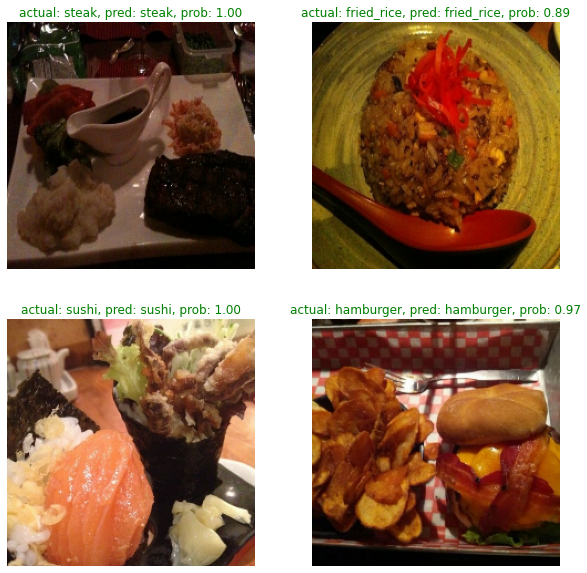

In [50]:
dataset_visualizer(test_data_10_percent, model_1)